In [1]:
from sklearn import datasets
import xgboost as xgb
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import shap

In [2]:
data=pd.read_csv('C:/Users/saksh/Desktop/Rotman/Fall/CIBC/df_perfect_final.csv',index_col=0)

In [3]:
data.shape

(5363, 48)

In [4]:
data.head()

,investor_participants,Round_1_amount,Round_2_amount,Round_3_amount,Round_4_amount,Round_5_amount,Round_6_amount,funding_rounds,funding_total_usd,relationships,...,games_video,cleantech,other_category,Round1_Missing_fg,Round2_Missing_fg,Round3_Missing_fg,Round4_Missing_fg,Round5_Missing_fg,cluster number,success
normalized_name,,,,,,,,,,,,,,,,,,,,,
wetpaint,9,0,5250000,9500000,25000000,0,0,3,39750000,17,...,0,0,0,1,0,0,0,0,0,1
slacker,17,0,13500000,40000000,0,9600000,0,6,73100000,16,...,0,0,1,1,0,0,1,0,1,1
livestream,1,2700000,10000000,0,0,0,1999973,4,14699973,24,...,1,0,0,0,0,1,1,1,0,1
ustream,10,1700000,11800000,46600000,0,0,0,3,60100000,27,...,1,0,0,0,0,0,0,0,0,1
topix,6,0,0,15000000,0,0,0,2,15000000,12,...,0,0,0,1,1,0,0,0,0,1


In [5]:
data.isna().sum()

investor_participants        0
Round_1_amount               0
Round_2_amount               0
Round_3_amount               0
Round_4_amount               0
Round_5_amount               0
Round_6_amount               0
funding_rounds               0
funding_total_usd            0
relationships                0
funding_velocity             0
FounderCounter               0
C_Level_Counter              0
female_fg                    0
dropout_fg                   0
count_degrees                0
school_counter               0
MBA_fg                       0
round1_fg                    0
round2_fg                    0
round3_fg                    0
round4_fg                    0
round5_fg                    0
round6_fg                    0
venture_capital_fg           0
age                          0
days_since_last_funding      0
city_ranked_other_city       0
city_ranked_top_five_city    0
city_ranked_top_ten_city     0
software                     0
biotech                      0
enterpri

In [6]:
data.dtypes

investor_participants          int64
Round_1_amount                 int64
Round_2_amount                 int64
Round_3_amount                 int64
Round_4_amount                 int64
Round_5_amount                 int64
Round_6_amount                 int64
funding_rounds                 int64
funding_total_usd              int64
relationships                  int64
funding_velocity             float64
FounderCounter                 int64
C_Level_Counter                int64
female_fg                      int64
dropout_fg                     int64
count_degrees                  int64
school_counter                 int64
MBA_fg                         int64
round1_fg                      int64
round2_fg                      int64
round3_fg                      int64
round4_fg                      int64
round5_fg                      int64
round6_fg                      int64
venture_capital_fg             int64
age                            int64
days_since_last_funding        int64
c

In [7]:
data=data.replace([np.inf,-np.inf],np.nan)

In [8]:
data=data.dropna()

In [9]:
data.shape

(5363, 48)

In [10]:
data.success=data.success.astype('category')

In [11]:
from sklearn import preprocessing
data_y=data.loc[:,"success"]
data_X=data.drop(["success"],axis=1)
# standardize the data attributes
standardized_X = preprocessing.scale(data_X)
standardized_y = preprocessing.scale(data_y)


In [12]:
from sklearn.model_selection import train_test_split
shap.initjs()
X_train, X_test, Y_train, Y_test = train_test_split(standardized_X, standardized_y, test_size=0.2)

In [13]:
model = XGBClassifier()
model.fit(X_train, Y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]


In [14]:
test=[round(value) for value in Y_test]

## Baseline

In [15]:
accuracy = accuracy_score(test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 68.69%


### Without Dmatrix

In [16]:
X_train, X_test, y_train, y_test= train_test_split(data_X,data_y, test_size=0.2, random_state=123)

xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)

# Fit the classifier to the training set
xg_cl.fit(X_train,y_train)

# Predict the labels of the test set: preds
preds = xg_cl.predict(X_test)

# Compute the accuracy: accuracy
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))

accuracy: 0.704567


In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, preds)

array([[692,  55],
       [262,  64]], dtype=int64)

### F1Score 

In [18]:
from sklearn.metrics import f1_score
f1_score(y_test, preds)

0.2876404494382023

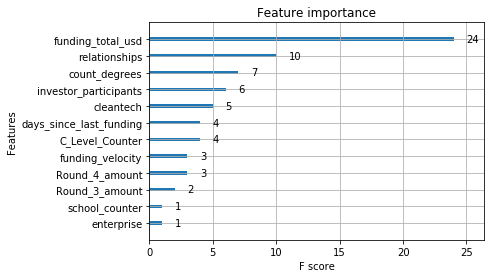

In [19]:
import matplotlib.pyplot as plt
xgb.plot_importance(xg_cl)
plt.show()

### Using Dmatrix 

In [20]:
startup_dmatrix = xgb.DMatrix(data=data_X, label=data_y)
params = {"objective":"binary:logistic", "max_depth":4}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=startup_dmatrix, params=params, 
                  nfold=5, num_boost_round=5, 
                  metrics="auc", as_pandas=True, seed=123)


# Print cv_results
print(cv_results)

# Extract and print final boosting round metric
print((cv_results["test-auc-mean"]).tail(1))

Series.base is deprecated and will be removed in a future version


   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.722981       0.004112       0.694872      0.004448
1        0.735616       0.003192       0.704115      0.006377
2        0.743750       0.003990       0.703610      0.006135
3        0.750853       0.002808       0.705505      0.003965
4        0.756435       0.002873       0.706121      0.004231
4    0.706121
Name: test-auc-mean, dtype: float64


### Grid Search

In [21]:
gbm_param_grid = {
    'colsample_bytree': [0.1,0.5, 0.8,1],
    'n_estimators': [10,25,50],
    'max_depth': [2,5,10,20],
    'eta_vals' : [0.001, 0.01, 0.1],
    'num_rounds' : [5, 10, 15]
}



In [22]:
    gbm = xgb.XGBClassifier()


In [23]:
grid_f1 = GridSearchCV(estimator=gbm,param_grid=gbm_param_grid,scoring='f1',cv=4,verbose=1)


In [24]:
grid_f1.fit(X_train,y_train)


Fitting 4 folds for each of 432 candidates, totalling 1728 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1728 out of 1728 | elapsed:  8.4min finished


GridSearchCV(cv=4, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.1, 0.5, 0.8, 1],
                         'eta_vals': [0.001, 0.01, 0.1],
                         'max_depth': [2, 5, 10, 20],
 

In [25]:
preds = grid_f1.predict(X_test)

In [26]:
print("Best parameters found: ", grid_f1.best_params_)
print("Best AUC found: ", (grid_f1.best_score_))

Best parameters found:  {'colsample_bytree': 0.8, 'eta_vals': 0.001, 'max_depth': 20, 'n_estimators': 10, 'num_rounds': 5}
Best AUC found:  0.3783487159632241


#### Best Fit model Grid Search

In [27]:
bestfit = xgb.XGBClassifier(objective='binary:logistic', seed=123,colsample_bytree=0.8,eta_vals=0.001,max_depth=20,n_estimators=10,num_rounds=5)

In [28]:
bestfit.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eta_vals=0.001, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, num_rounds=5, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=123, silent=None, subsample=1, verbosity=1)

In [29]:
preds = bestfit.predict(X_test)

### Shapley Values 

In [30]:
explainer = shap.TreeExplainer(bestfit)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [31]:
shap_values = explainer.shap_values(X_train)

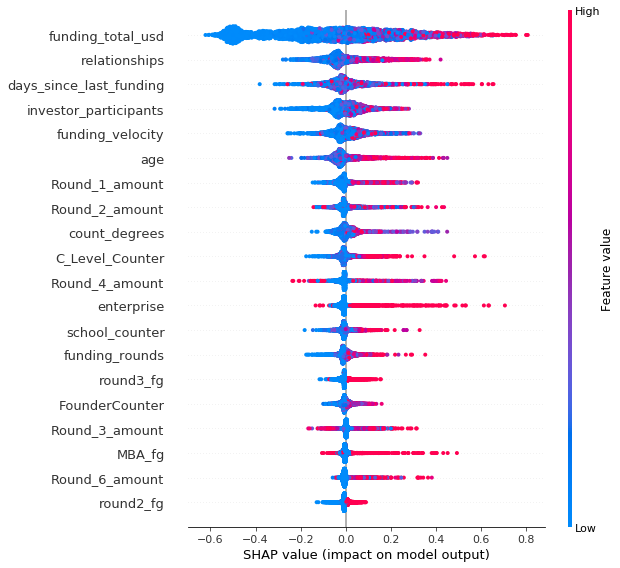

In [32]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

### Confusion matrix 

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix(y_test, preds)

array([[662,  85],
       [217, 109]], dtype=int64)

In [34]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.75      0.89      0.81       747
           1       0.56      0.33      0.42       326

    accuracy                           0.72      1073
   macro avg       0.66      0.61      0.62      1073
weighted avg       0.70      0.72      0.69      1073



### F1 Score 

#### This is the F1 score for a binary target variable. 

In [35]:
from sklearn.metrics import f1_score
f1_score(y_test, preds)

0.4192307692307692

#### This is the weighted class F1 score. Calculates weighted F1 score for each class 

In [36]:
from sklearn.metrics import f1_score
f1_score(y_test, preds,average="weighted")

0.6942474681754489

#### This is the equally weighted F1 score. Does note take class imbalance into account

In [37]:
from sklearn.metrics import f1_score
f1_score(y_test, preds,average="macro")

0.616749455956098

### Accuracy 

In [38]:
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))

accuracy: 0.718546


In [39]:
print("Best parameters found: ", grid_f1.best_params_)
print("Best AUC found: ", (grid_f1.best_score_))


Best parameters found:  {'colsample_bytree': 0.8, 'eta_vals': 0.001, 'max_depth': 20, 'n_estimators': 10, 'num_rounds': 5}
Best AUC found:  0.3783487159632241


In [40]:
grid_acc = GridSearchCV(estimator=gbm,param_grid=gbm_param_grid,scoring='accuracy',cv=4,verbose=1)

In [41]:
grid_acc.fit(data_X,data_y)


Fitting 4 folds for each of 432 candidates, totalling 1728 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1728 out of 1728 | elapsed: 10.5min finished


GridSearchCV(cv=4, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.1, 0.5, 0.8, 1],
                         'eta_vals': [0.001, 0.01, 0.1],
                         'max_depth': [2, 5, 10, 20],
 

In [42]:
print("Best parameters found: ", grid_acc.best_params_)
print("Best AUC found: ", (grid_acc.best_score_))

Best parameters found:  {'colsample_bytree': 0.1, 'eta_vals': 0.001, 'max_depth': 10, 'n_estimators': 25, 'num_rounds': 5}
Best AUC found:  0.7074397308758222


### Random Search 

In [43]:
from sklearn.model_selection import RandomizedSearchCV

In [44]:
randomized_f1 = RandomizedSearchCV(estimator=gbm,param_distributions=gbm_param_grid,n_iter=100,cv=4,verbose=1,scoring='f1')

In [45]:
randomized_f1.fit(data_X,data_y)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  2.7min finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...t=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated',

In [46]:
print("Best parameters found: ", randomized_f1.best_params_)
print("Best AUC found: ", (randomized_f1.best_score_))

Best parameters found:  {'num_rounds': 10, 'n_estimators': 10, 'max_depth': 20, 'eta_vals': 0.01, 'colsample_bytree': 1}
Best AUC found:  0.32205995033671936


In [47]:
bestfit_Random = xgb.XGBClassifier(objective='binary:logistic', seed=123,colsample_bytree=1,eta_vals=0.001,max_depth=20,n_estimators=10,num_rounds=15)

In [48]:
bestfit_Random.fit(X_train,y_train)
preds = bestfit_Random.predict(X_test)

In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix(y_test, preds)

array([[640, 107],
       [229,  97]], dtype=int64)

In [50]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.74      0.86      0.79       747
           1       0.48      0.30      0.37       326

    accuracy                           0.69      1073
   macro avg       0.61      0.58      0.58      1073
weighted avg       0.66      0.69      0.66      1073



### Bestfit Model RandomSearch 

In [51]:
bestfit_random = xgb.XGBClassifier(objective='binary:logistic', seed=123,colsample_bytree=1,eta_vals=0.001,max_depth=20,n_estimators=10,num_rounds=15)

In [52]:
bestfit_random.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta_vals=0.001, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, num_rounds=15, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=123, silent=None, subsample=1, verbosity=1)

In [53]:
preds = bestfit_random.predict(X_test)

In [54]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, preds)

array([[640, 107],
       [229,  97]], dtype=int64)

In [55]:
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))

accuracy: 0.686859


In [56]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.74      0.86      0.79       747
           1       0.48      0.30      0.37       326

    accuracy                           0.69      1073
   macro avg       0.61      0.58      0.58      1073
weighted avg       0.66      0.69      0.66      1073



In [57]:
explainer = shap.TreeExplainer(bestfit_random)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [58]:
shap_values = explainer.shap_values(X_train)

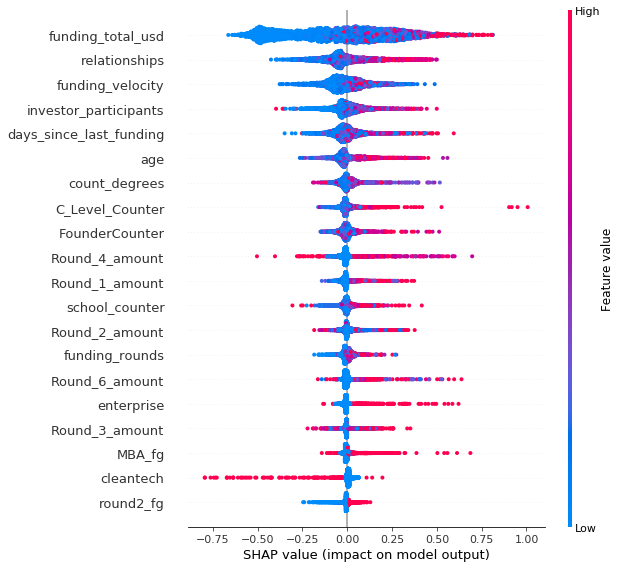

In [59]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

### Deep Feature Synthesis 

In [60]:
import featuretools as ft

In [61]:
data=pd.read_csv('C:/Users/saksh/Desktop/Rotman/Fall/CIBC/df_perfect_final.csv')

In [62]:
data.head()

,normalized_name,investor_participants,Round_1_amount,Round_2_amount,Round_3_amount,Round_4_amount,Round_5_amount,Round_6_amount,funding_rounds,funding_total_usd,...,games_video,cleantech,other_category,Round1_Missing_fg,Round2_Missing_fg,Round3_Missing_fg,Round4_Missing_fg,Round5_Missing_fg,cluster number,success
0,wetpaint,9,0,5250000,9500000,25000000,0,0,3,39750000,...,0,0,0,1,0,0,0,0,0,1
1,slacker,17,0,13500000,40000000,0,9600000,0,6,73100000,...,0,0,1,1,0,0,1,0,1,1
2,livestream,1,2700000,10000000,0,0,0,1999973,4,14699973,...,1,0,0,0,0,1,1,1,0,1
3,ustream,10,1700000,11800000,46600000,0,0,0,3,60100000,...,1,0,0,0,0,0,0,0,0,1
4,topix,6,0,0,15000000,0,0,0,2,15000000,...,0,0,0,1,1,0,0,0,0,1


In [63]:
es = ft.EntitySet(id = 'data')

In [64]:
es = es.entity_from_dataframe(entity_id = 'data', 
                              dataframe = data,
                              index = 'normalized_name')

In [65]:
es['data']

Entity: data
  Variables:
    normalized_name (dtype: index)
    investor_participants (dtype: numeric)
    Round_1_amount (dtype: numeric)
    Round_2_amount (dtype: numeric)
    Round_3_amount (dtype: numeric)
    Round_4_amount (dtype: numeric)
    Round_5_amount (dtype: numeric)
    Round_6_amount (dtype: numeric)
    funding_rounds (dtype: numeric)
    funding_total_usd (dtype: numeric)
    relationships (dtype: numeric)
    funding_velocity (dtype: numeric)
    FounderCounter (dtype: numeric)
    C_Level_Counter (dtype: numeric)
    female_fg (dtype: numeric)
    dropout_fg (dtype: numeric)
    count_degrees (dtype: numeric)
    school_counter (dtype: numeric)
    MBA_fg (dtype: numeric)
    round1_fg (dtype: numeric)
    round2_fg (dtype: numeric)
    round3_fg (dtype: numeric)
    round4_fg (dtype: numeric)
    round5_fg (dtype: numeric)
    round6_fg (dtype: numeric)
    venture_capital_fg (dtype: numeric)
    age (dtype: numeric)
    days_since_last_funding (dtype: numeric)
 

In [66]:
features, feature_names = ft.dfs(entityset = es, target_entity = 'data', 
                                 agg_primitives = ['mean', 'max', 'percent_true', 'last'])

In [67]:
feature_names

[<Feature: investor_participants>,
 <Feature: Round_1_amount>,
 <Feature: Round_2_amount>,
 <Feature: Round_3_amount>,
 <Feature: Round_4_amount>,
 <Feature: Round_5_amount>,
 <Feature: Round_6_amount>,
 <Feature: funding_rounds>,
 <Feature: funding_total_usd>,
 <Feature: relationships>,
 <Feature: funding_velocity>,
 <Feature: FounderCounter>,
 <Feature: C_Level_Counter>,
 <Feature: female_fg>,
 <Feature: dropout_fg>,
 <Feature: count_degrees>,
 <Feature: school_counter>,
 <Feature: MBA_fg>,
 <Feature: round1_fg>,
 <Feature: round2_fg>,
 <Feature: round3_fg>,
 <Feature: round4_fg>,
 <Feature: round5_fg>,
 <Feature: round6_fg>,
 <Feature: venture_capital_fg>,
 <Feature: age>,
 <Feature: days_since_last_funding>,
 <Feature: city_ranked_other_city>,
 <Feature: city_ranked_top_five_city>,
 <Feature: city_ranked_top_ten_city>,
 <Feature: software>,
 <Feature: biotech>,
 <Feature: enterprise>,
 <Feature: web>,
 <Feature: mobile>,
 <Feature: advertising>,
 <Feature: ecommerce>,
 <Feature: analytics>,
 <Feature: games_video>,
 <Feature: cleantech>,
 <Feature: other_category>,
 <Feature: Round1_Missing_fg>,
 <Feature: Round2_Missing_fg>,
 <Feature: Round3_Missing_fg>,
 <Feature: Round4_Missing_fg>,
 <Feature: Round5_Missing_fg>,
 <Feature: cluster number>,
 <Feature: success>]

In [68]:
features.head()

,investor_participants,Round_1_amount,Round_2_amount,Round_3_amount,Round_4_amount,Round_5_amount,Round_6_amount,funding_rounds,funding_total_usd,relationships,...,games_video,cleantech,other_category,Round1_Missing_fg,Round2_Missing_fg,Round3_Missing_fg,Round4_Missing_fg,Round5_Missing_fg,cluster number,success
normalized_name,,,,,,,,,,,,,,,,,,,,,
wetpaint,9,0,5250000,9500000,25000000,0,0,3,39750000,17,...,0,0,0,1,0,0,0,0,0,1
slacker,17,0,13500000,40000000,0,9600000,0,6,73100000,16,...,0,0,1,1,0,0,1,0,1,1
livestream,1,2700000,10000000,0,0,0,1999973,4,14699973,24,...,1,0,0,0,0,1,1,1,0,1
ustream,10,1700000,11800000,46600000,0,0,0,3,60100000,27,...,1,0,0,0,0,0,0,0,0,1
topix,6,0,0,15000000,0,0,0,2,15000000,12,...,0,0,0,1,1,0,0,0,0,1


### SMOTE

In [69]:
from imblearn.over_sampling import SMOTE
X_train,y_train = SMOTE(random_state=10, k_neighbors=100).fit_resample(X_train,y_train)

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be importe

In [70]:
bestfit_random = xgb.XGBClassifier(objective='binary:logistic', seed=123,colsample_bytree=1,eta_vals=0.001,max_depth=20,n_estimators=10,num_rounds=15)

In [71]:
bestfit_random.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta_vals=0.001, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, num_rounds=15, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=123, silent=None, subsample=1, verbosity=1)

In [72]:
preds = bestfit_random.predict(X_test)

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46'] ['investor_participants', 'Round_1_amount', 'Round_2_amount', 'Round_3_amount', 'Round_4_amount', 'Round_5_amount', 'Round_6_amount', 'funding_rounds', 'funding_total_usd', 'relationships', 'funding_velocity', 'FounderCounter', 'C_Level_Counter', 'female_fg', 'dropout_fg', 'count_degrees', 'school_counter', 'MBA_fg', 'round1_fg', 'round2_fg', 'round3_fg', 'round4_fg', 'round5_fg', 'round6_fg', 'venture_capital_fg', 'age', 'days_since_last_funding', 'city_ranked_other_city', 'city_ranked_top_five_city', 'city_ranked_top_ten_city', 'software', 'biotech', 'enterprise', 'web', 'mobile', 'advertising', 'ecommerce', 'analytics', 'games_video', 'cleantech', 'other_category', 'Round1_Missing_fg', 'Round2_Missing_fg', 'Round3_Missing_fg', 'Round4_Missing_fg', 'Round5_Missing_fg', 'cluster number']
expected f27, f25, f15, f23, f12, f0, f7, f38, f39, f3, f36, f40, f29, f37, f2, f16, f19, f10, f43, f6, f13, f8, f1, f5, f11, f24, f41, f9, f17, f42, f46, f22, f35, f32, f33, f45, f20, f26, f14, f30, f4, f18, f21, f31, f44, f28, f34 in input data
training data did not have the following fields: Round2_Missing_fg, Round3_Missing_fg, enterprise, days_since_last_funding, Round5_Missing_fg, dropout_fg, Round_6_amount, round6_fg, cleantech, Round1_Missing_fg, Round_4_amount, investor_participants, Round_1_amount, MBA_fg, round2_fg, games_video, round5_fg, web, software, C_Level_Counter, Round_5_amount, relationships, ecommerce, city_ranked_top_ten_city, age, analytics, funding_velocity, city_ranked_other_city, Round_3_amount, round4_fg, round1_fg, mobile, female_fg, funding_rounds, count_degrees, Round_2_amount, city_ranked_top_five_city, biotech, FounderCounter, Round4_Missing_fg, round3_fg, cluster number, other_category, advertising, funding_total_usd, venture_capital_fg, school_counter